In [55]:
import gc
import time
import numpy as np
import matplotlib.pyplot as plt
from graph import Graph
from generator import Generator
from algorithm import TarjansSccAlgorithm

In [56]:
N_VALUES = [20, 40, 60, 80, 100, 120, 140,160, 180,200]
DELTA_VALUES = [ 20, 40, 60, 80]
GENERATE_COUNT = 100

In [57]:
ALL_RESULTS = {
    'adj_list': {},
    'adj_matrix': {},
    'raw_data': {}
}

In [58]:
def generate_graphs(n, delta_values, count):
    graphs = {}
    for delta in delta_values:
        generator = Generator(n, delta)
        graphs[delta] = []
        for _ in range(count):
            graphs[delta].append((generator.vertices, generator.generate_random_graph()))
    return graphs

In [59]:
def benchmark_implementation(generated_graphs, delta_values, use_list=True):
    time_values = np.zeros((len(delta_values), GENERATE_COUNT), dtype=float)
    
    for k_idx, delta in enumerate(delta_values):
        for graph_idx, (vertices, edges) in enumerate(generated_graphs[delta]):
            g = Graph(vertices, edges)
            
            if use_list:
                representation = g.adjacency_list
                method = TarjansSccAlgorithm().find_scc_adjacency_list
            else:
                representation = g.adjacency_matrix
                method = TarjansSccAlgorithm().find_scc_adjacency_matrix
            
            gc.disable()
            start = time.perf_counter()
            method(representation)
            end = time.perf_counter()
            gc.enable()
            
            time_values[k_idx, graph_idx] = end - start
    
    return time_values

In [60]:
def store_results(n, time_values_list, time_values_matrix):
    median_list = np.median(time_values_list, axis=1) * 1000
    median_matrix = np.median(time_values_matrix, axis=1) * 1000
    
    ALL_RESULTS['adj_list'][n] = {delta: median_list[i] for i, delta in enumerate(DELTA_VALUES)}
    ALL_RESULTS['adj_matrix'][n] = {delta: median_matrix[i] for i, delta in enumerate(DELTA_VALUES)}
    ALL_RESULTS['raw_data'][n] = {
        'list': time_values_list,
        'matrix': time_values_matrix
    }
    
    print(f"\n✓ Results stored for n={n}")
    print(f"  List median range: {median_list.min():.4f} - {median_list.max():.4f} ms")
    print(f"  Matrix median range: {median_matrix.min():.4f} - {median_matrix.max():.4f} ms")

In [61]:
for n in N_VALUES:
    print(f"\n{'='*70}")
    print(f"Running benchmarks for n={n}")
    print(f"{'='*70}")
    
    print(f"Generating {GENERATE_COUNT} graphs for each δ value...")
    generated_graphs = generate_graphs(n, DELTA_VALUES, GENERATE_COUNT)
    
    print("Benchmarking adjacency list...")
    time_values_list = benchmark_implementation(generated_graphs, DELTA_VALUES, use_list=True)
    
    print("Benchmarking adjacency matrix...")
    time_values_matrix = benchmark_implementation(generated_graphs, DELTA_VALUES, use_list=False)
    
    store_results(n, time_values_list, time_values_matrix)


Running benchmarks for n=20
Generating 100 graphs for each δ value...
Benchmarking adjacency list...
Benchmarking adjacency matrix...

✓ Results stored for n=20
  List median range: 0.0365 - 0.0656 ms
  Matrix median range: 0.0872 - 0.1259 ms

Running benchmarks for n=40
Generating 100 graphs for each δ value...
Benchmarking adjacency list...
Benchmarking adjacency matrix...

✓ Results stored for n=40
  List median range: 0.0918 - 0.2568 ms
  Matrix median range: 0.2723 - 0.5220 ms

Running benchmarks for n=60
Generating 100 graphs for each δ value...
Benchmarking adjacency list...
Benchmarking adjacency matrix...

✓ Results stored for n=60
  List median range: 0.1656 - 0.6094 ms
  Matrix median range: 0.5763 - 0.9514 ms

Running benchmarks for n=80
Generating 100 graphs for each δ value...
Benchmarking adjacency list...
Benchmarking adjacency matrix...

✓ Results stored for n=80
  List median range: 0.3119 - 1.0501 ms
  Matrix median range: 0.9495 - 1.7202 ms

Running benchmarks for 

In [62]:
def plot_all_n_comparison():    
    fig = plt.figure(figsize=(18, 12))
    
    ax1 = plt.subplot(2, 3, 1)
    for n in N_VALUES:
        deltas = list(ALL_RESULTS['adj_list'][n].keys())
        times = list(ALL_RESULTS['adj_list'][n].values())
        ax1.plot(deltas, times, marker='o', linewidth=2, markersize=8, label=f'n={n}')
    ax1.set_xlabel('Параметр щільності (δ)', fontsize=11)
    ax1.set_ylabel('Медіанний час (мс)', fontsize=11)
    ax1.set_title('Список суміжності - всі n', fontsize=12, fontweight='bold')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    ax2 = plt.subplot(2, 3, 2)
    for n in N_VALUES:
        deltas = list(ALL_RESULTS['adj_matrix'][n].keys())
        times = list(ALL_RESULTS['adj_matrix'][n].values())
        ax2.plot(deltas, times, marker='s', linewidth=2, markersize=8, label=f'n={n}')
    ax2.set_xlabel('Параметр щільності (δ)', fontsize=11)
    ax2.set_ylabel('Медіанний час (мс)', fontsize=11)
    ax2.set_title('Матриця суміжності - всі n', fontsize=12, fontweight='bold')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    ax3 = plt.subplot(2, 3, 3)
    for n in N_VALUES:
        speedups = []
        for delta in DELTA_VALUES:
            list_time = ALL_RESULTS['adj_list'][n][delta]
            matrix_time = ALL_RESULTS['adj_matrix'][n][delta]
            speedup = matrix_time / list_time if list_time > 0 else 0
            speedups.append(speedup)
        ax3.plot(DELTA_VALUES, speedups, marker='^', linewidth=2, markersize=8, label=f'n={n}')
    ax3.axhline(y=1, color='red', linestyle='--', alpha=0.5, label='Однакова швидкість')
    ax3.set_xlabel('Параметр щільності (δ)', fontsize=11)
    ax3.set_ylabel('Відношення (Matrix / List)', fontsize=11)
    ax3.set_title('Швидкість: Матриця vs Список', fontsize=12, fontweight='bold')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    ax4 = plt.subplot(2, 3, 4)
    mid_delta = DELTA_VALUES[len(DELTA_VALUES)//2]
    list_times_by_n = [ALL_RESULTS['adj_list'][n][mid_delta] for n in N_VALUES]
    matrix_times_by_n = [ALL_RESULTS['adj_matrix'][n][mid_delta] for n in N_VALUES]
    ax4.plot(N_VALUES, list_times_by_n, marker='o', linewidth=2.5, markersize=10, 
             label='Список суміжності', color='#2E86AB')
    ax4.plot(N_VALUES, matrix_times_by_n, marker='s', linewidth=2.5, markersize=10, 
             label='Матриця суміжності', color='#A23B72')
    ax4.set_xlabel('Розмір графа (n)', fontsize=11)
    ax4.set_ylabel('Медіанний час (мс)', fontsize=11)
    ax4.set_title(f'Масштабування з n (δ={mid_delta})', fontsize=12, fontweight='bold')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    ax5 = plt.subplot(2, 3, 5)
    list_data = np.array([[ALL_RESULTS['adj_list'][n][d] for d in DELTA_VALUES] for n in N_VALUES])
    im1 = ax5.imshow(list_data, aspect='auto', cmap='YlOrRd', interpolation='nearest')
    ax5.set_xticks(range(len(DELTA_VALUES)))
    ax5.set_xticklabels(DELTA_VALUES)
    ax5.set_yticks(range(len(N_VALUES)))
    ax5.set_yticklabels(N_VALUES)
    ax5.set_xlabel('δ', fontsize=11)
    ax5.set_ylabel('n', fontsize=11)
    ax5.set_title('Теплова карта - Список', fontsize=12, fontweight='bold')
    plt.colorbar(im1, ax=ax5, label='Час (мс)')
    
    ax6 = plt.subplot(2, 3, 6)
    matrix_data = np.array([[ALL_RESULTS['adj_matrix'][n][d] for d in DELTA_VALUES] for n in N_VALUES])
    im2 = ax6.imshow(matrix_data, aspect='auto', cmap='YlOrRd', interpolation='nearest')
    ax6.set_xticks(range(len(DELTA_VALUES)))
    ax6.set_xticklabels(DELTA_VALUES)
    ax6.set_yticks(range(len(N_VALUES)))
    ax6.set_yticklabels(N_VALUES)
    ax6.set_xlabel('δ', fontsize=11)
    ax6.set_ylabel('n', fontsize=11)
    ax6.set_title('Теплова карта - Матриця', fontsize=12, fontweight='bold')
    plt.colorbar(im2, ax=ax6, label='Час (мс)')
    
    plt.tight_layout()
    plt.show()

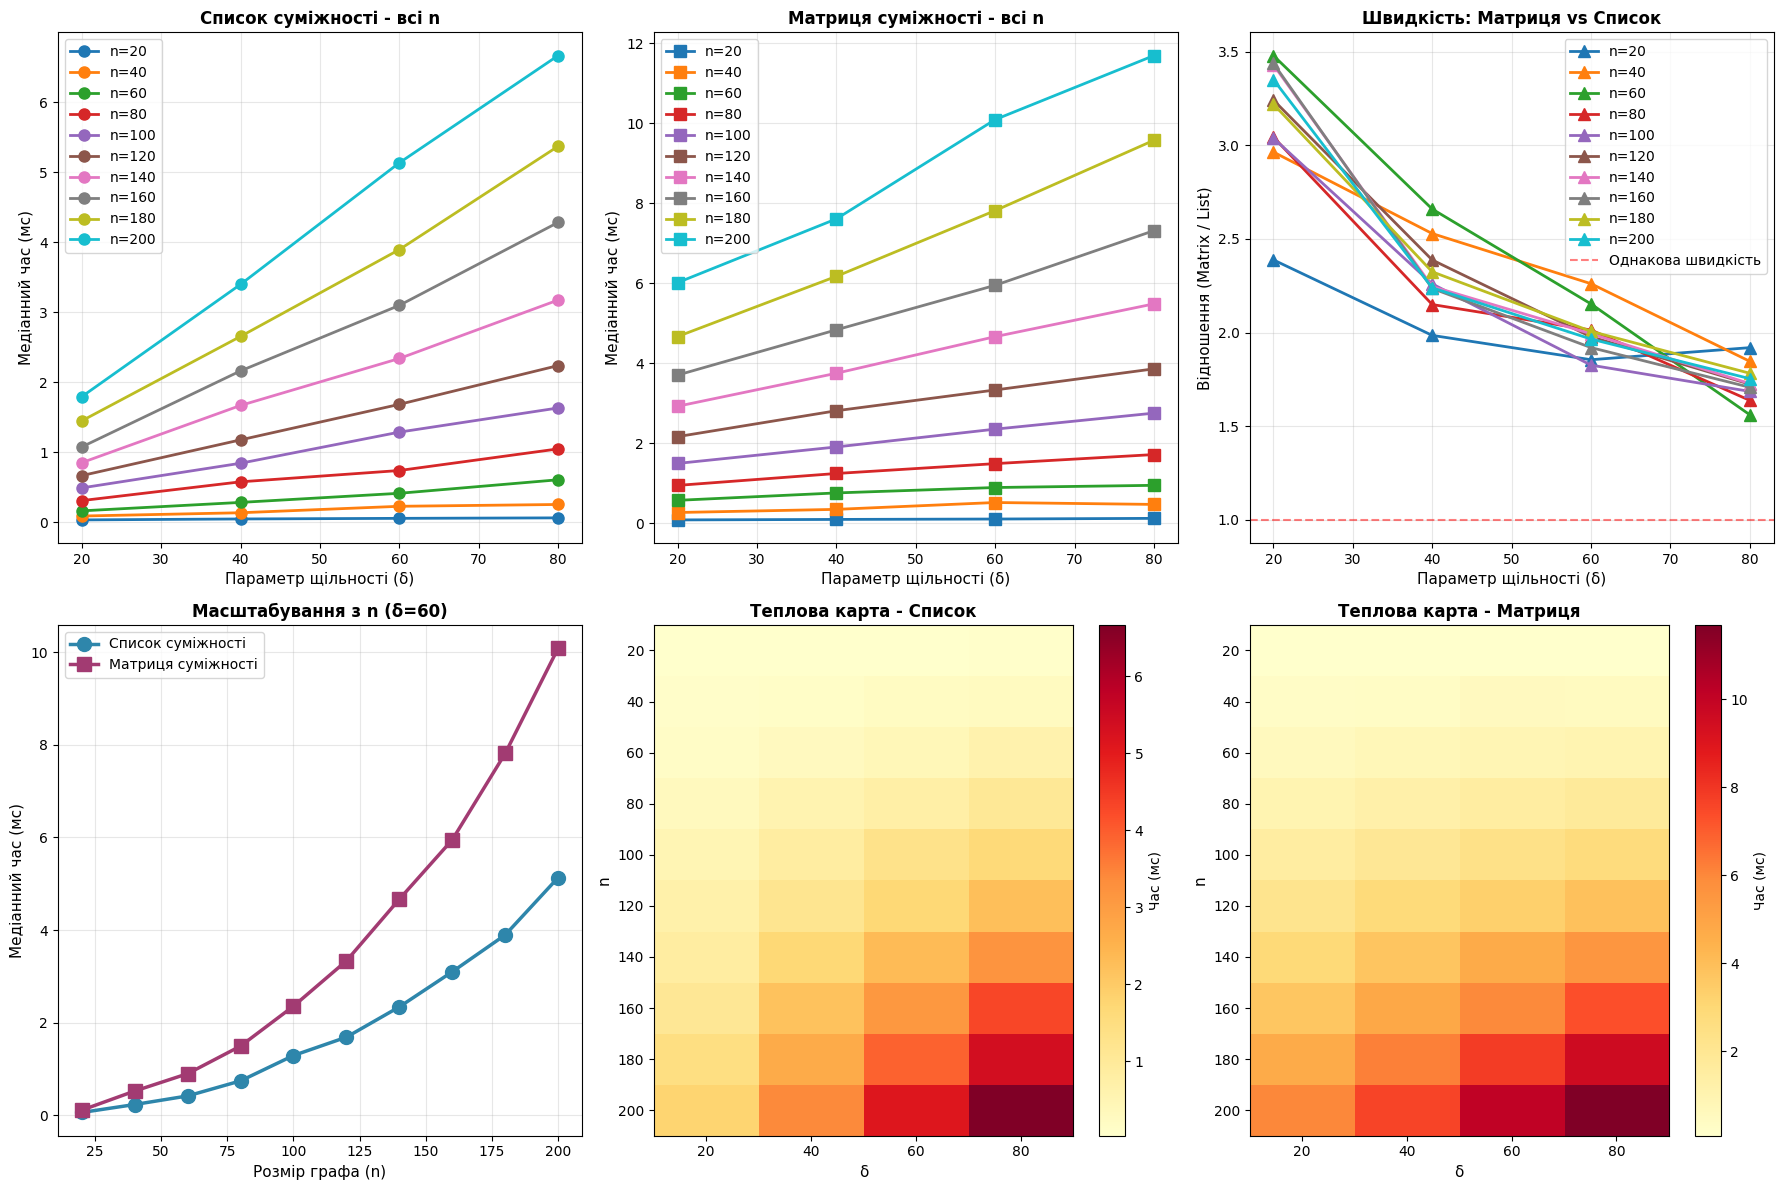

In [63]:
plot_all_n_comparison()

In [ ]:
# ANALYSYS FOR EACH N

In [87]:
def plot_individual_n(n, all_results, delta_values):
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
    
    time_list = all_results['raw_data'][n]['list']
    time_matrix = all_results['raw_data'][n]['matrix']
    
    ax1.boxplot([time_list[i] * 1000 for i in range(len(delta_values))], 
                labels=delta_values)
    ax1.set_xlabel('δ', fontsize=12)
    ax1.set_ylabel('Час (мс)', fontsize=12)
    ax1.set_title(f'Розподіл - Список суміжності (n={n})', fontsize=13, fontweight='bold')
    ax1.grid(True, alpha=0.3, axis='y')
    
    ax2.boxplot([time_matrix[i] * 1000 for i in range(len(delta_values))], 
                labels=delta_values)
    ax2.set_xlabel('δ', fontsize=12)
    ax2.set_ylabel('Час (мс)', fontsize=12)
    ax2.set_title(f'Розподіл - Матриця суміжності (n={n})', fontsize=13, fontweight='bold')
    ax2.grid(True, alpha=0.3, axis='y')
    
    median_list = np.median(time_list, axis=1) * 1000
    median_matrix = np.median(time_matrix, axis=1) * 1000
    
    ax3.plot(delta_values, median_list, marker='o', linewidth=2.5, markersize=10, 
             label='Список суміжності', color='#2E86AB')
    ax3.plot(delta_values, median_matrix, marker='s', linewidth=2.5, markersize=10, 
             label='Матриця суміжності', color='#A23B72')
    ax3.set_xlabel('δ', fontsize=12)
    ax3.set_ylabel('Медіанний час (мс)', fontsize=12)
    ax3.set_title(f'Порівняння реалізацій (n={n})', fontsize=13, fontweight='bold')
    ax3.legend(fontsize=11)
    ax3.grid(True, alpha=0.3)
    
    std_list = np.std(time_list, axis=1) * 1000
    std_matrix = np.std(time_matrix, axis=1) * 1000
    
    x = np.arange(len(delta_values))
    width = 0.35
    ax4.bar(x - width/2, std_list, width, label='Список', color='#2E86AB', alpha=0.7)
    ax4.bar(x + width/2, std_matrix, width, label='Матриця', color='#A23B72', alpha=0.7)
    ax4.set_xlabel('δ', fontsize=12)
    ax4.set_ylabel('Стандартне відхилення (мс)', fontsize=12)
    ax4.set_title(f'Стабільність виконання (n={n})', fontsize=13, fontweight='bold')
    ax4.set_xticks(x)
    ax4.set_xticklabels(delta_values)
    ax4.legend(fontsize=11)
    ax4.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()

/var/folders/62/q1myyln54rqcbpgt5c6jf_jc0000gn/T/ipykernel_28773/206366845.py:8: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax1.boxplot([time_list[i] * 1000 for i in range(len(delta_values))],
/var/folders/62/q1myyln54rqcbpgt5c6jf_jc0000gn/T/ipykernel_28773/206366845.py:15: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax2.boxplot([time_matrix[i] * 1000 for i in range(len(delta_values))],


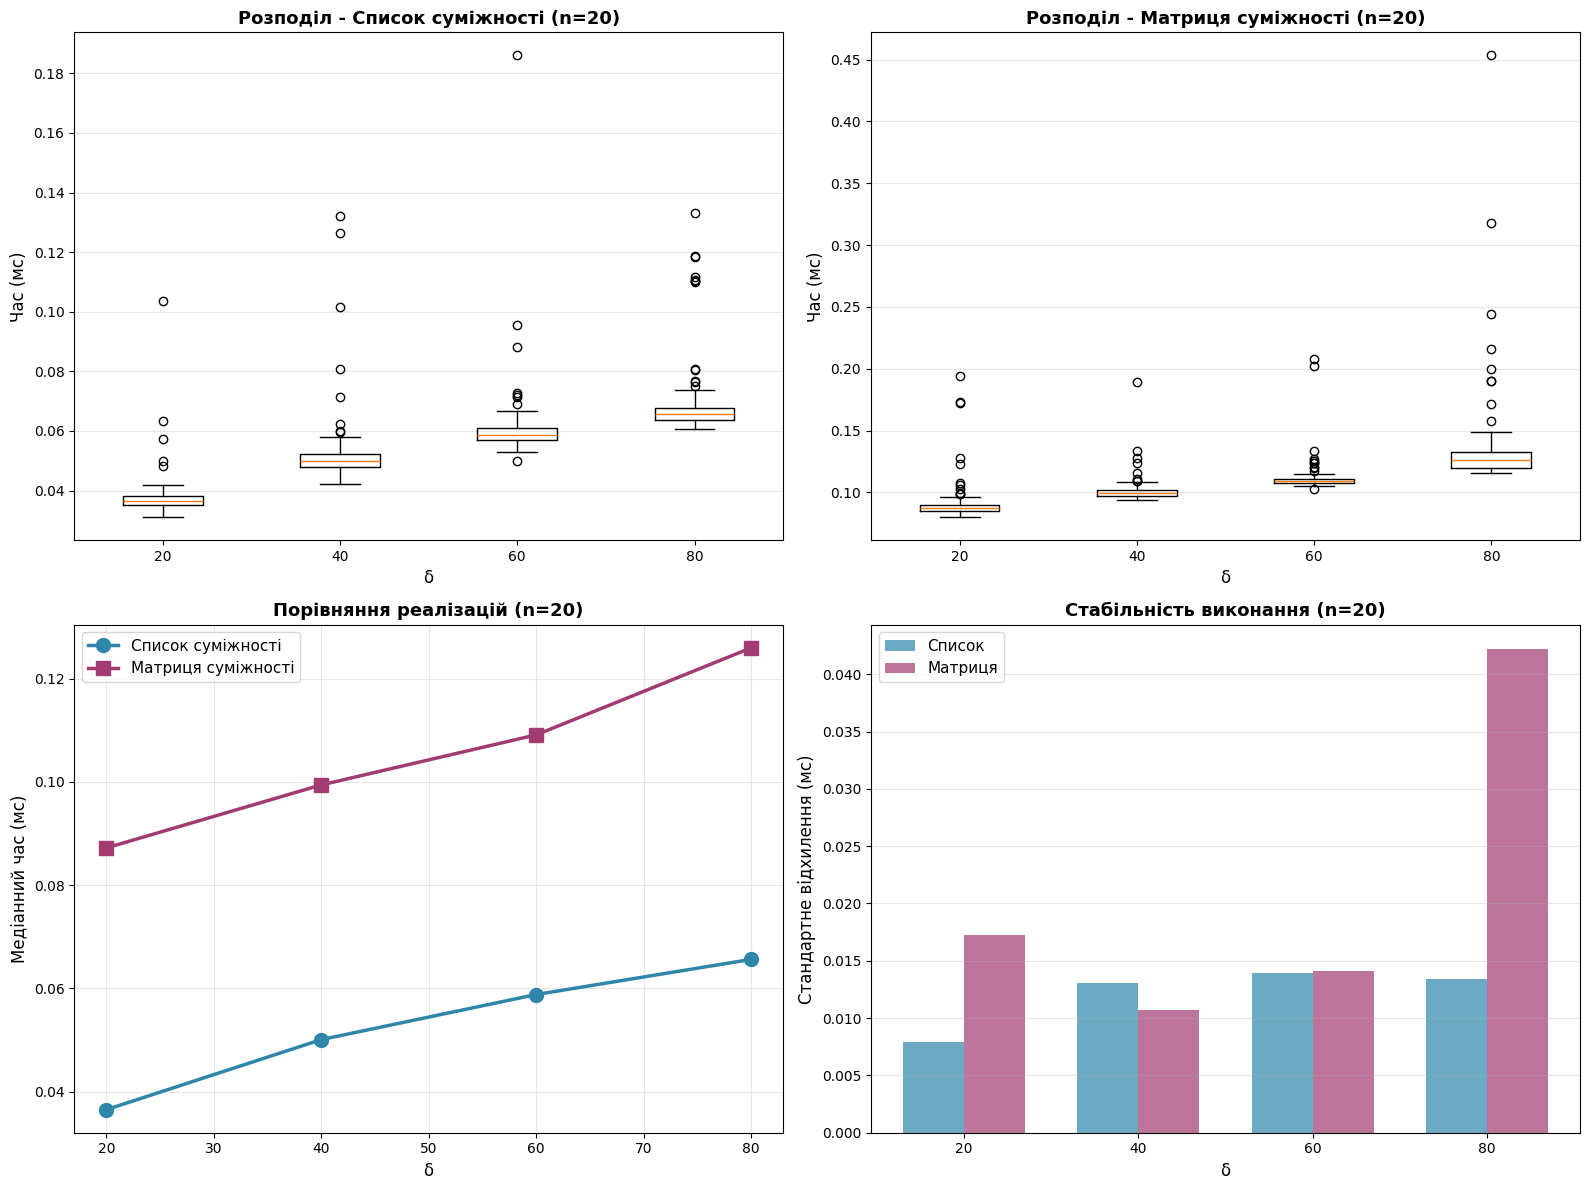

/var/folders/62/q1myyln54rqcbpgt5c6jf_jc0000gn/T/ipykernel_28773/206366845.py:8: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax1.boxplot([time_list[i] * 1000 for i in range(len(delta_values))],
/var/folders/62/q1myyln54rqcbpgt5c6jf_jc0000gn/T/ipykernel_28773/206366845.py:15: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax2.boxplot([time_matrix[i] * 1000 for i in range(len(delta_values))],


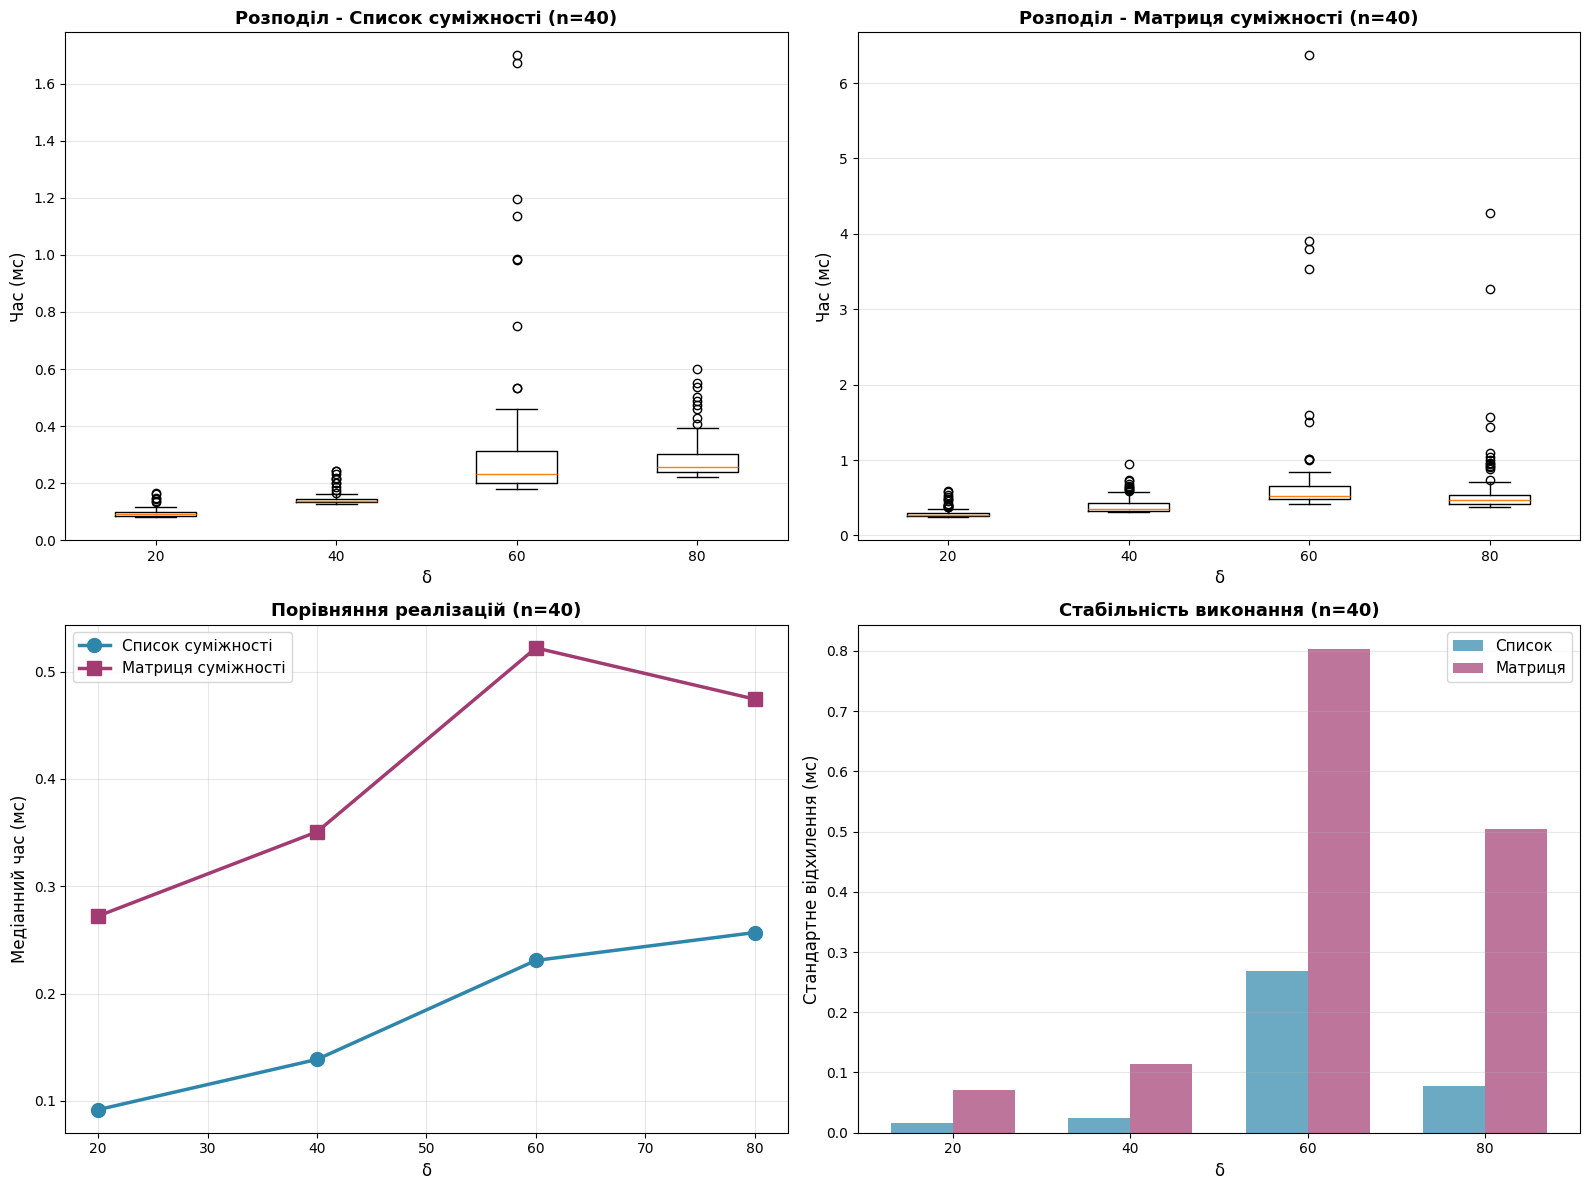

/var/folders/62/q1myyln54rqcbpgt5c6jf_jc0000gn/T/ipykernel_28773/206366845.py:8: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax1.boxplot([time_list[i] * 1000 for i in range(len(delta_values))],
/var/folders/62/q1myyln54rqcbpgt5c6jf_jc0000gn/T/ipykernel_28773/206366845.py:15: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax2.boxplot([time_matrix[i] * 1000 for i in range(len(delta_values))],


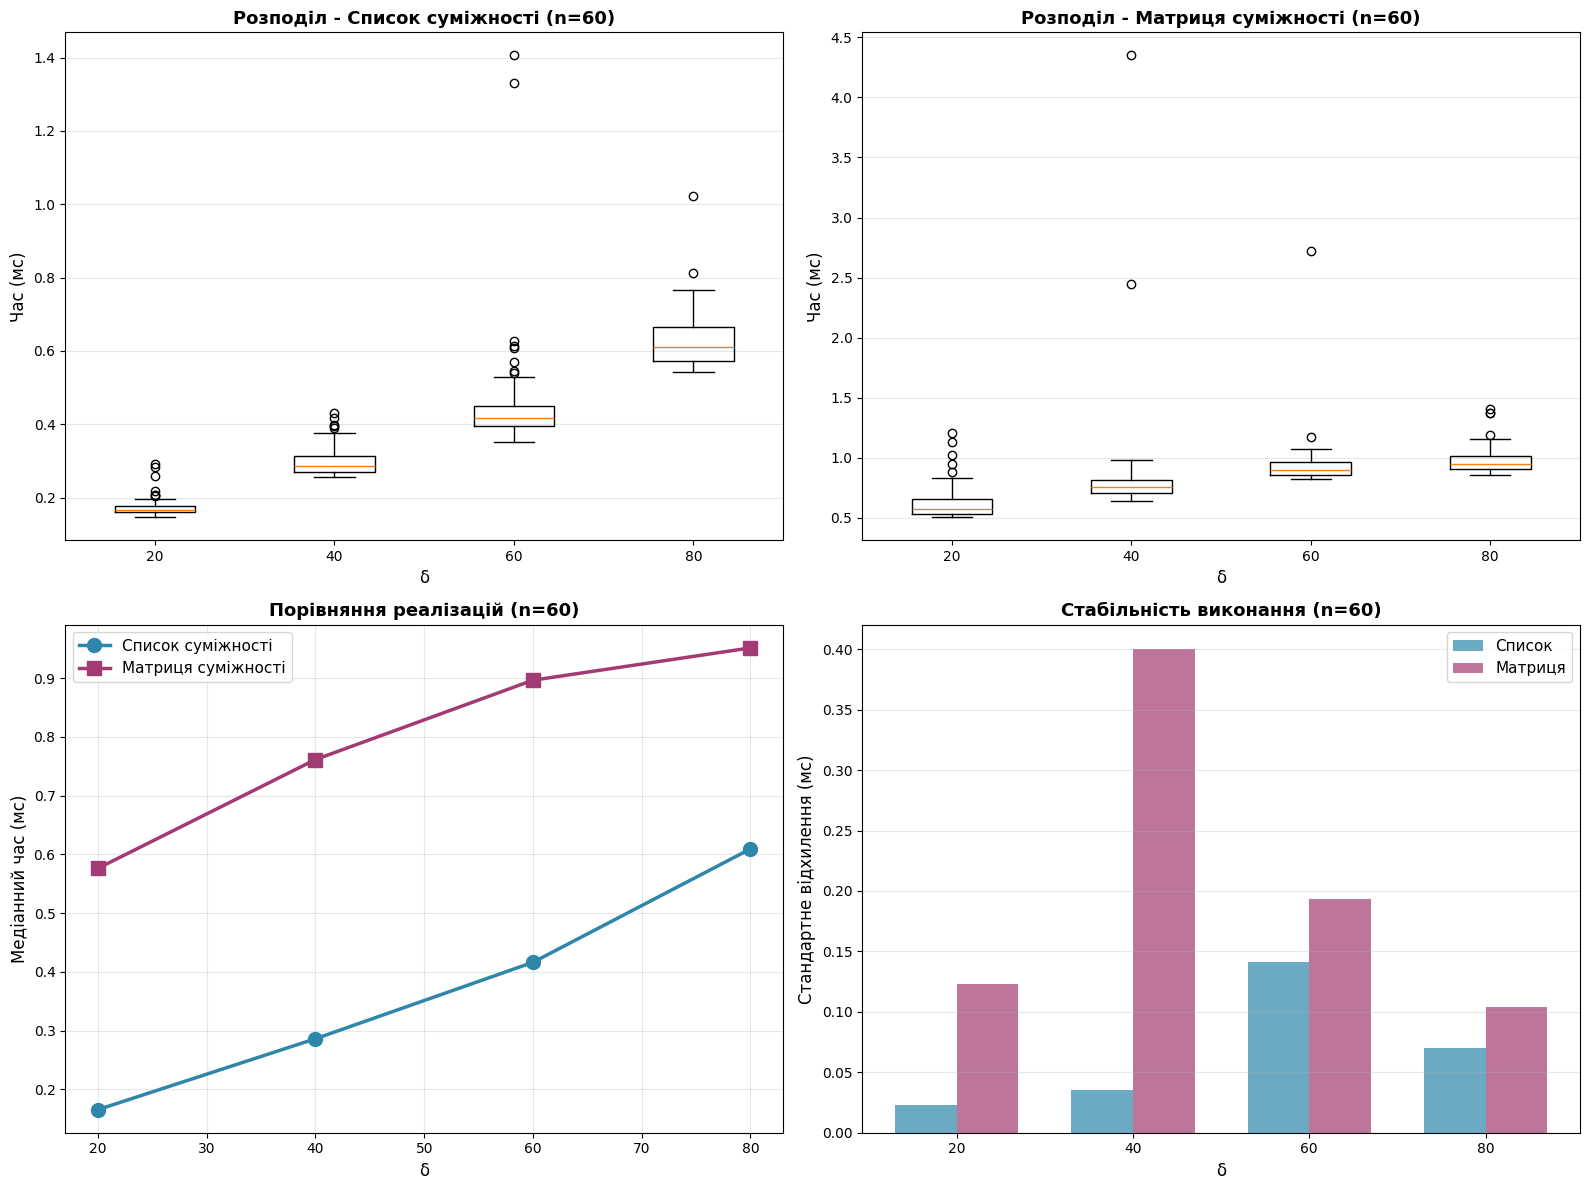

/var/folders/62/q1myyln54rqcbpgt5c6jf_jc0000gn/T/ipykernel_28773/206366845.py:8: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax1.boxplot([time_list[i] * 1000 for i in range(len(delta_values))],
/var/folders/62/q1myyln54rqcbpgt5c6jf_jc0000gn/T/ipykernel_28773/206366845.py:15: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax2.boxplot([time_matrix[i] * 1000 for i in range(len(delta_values))],


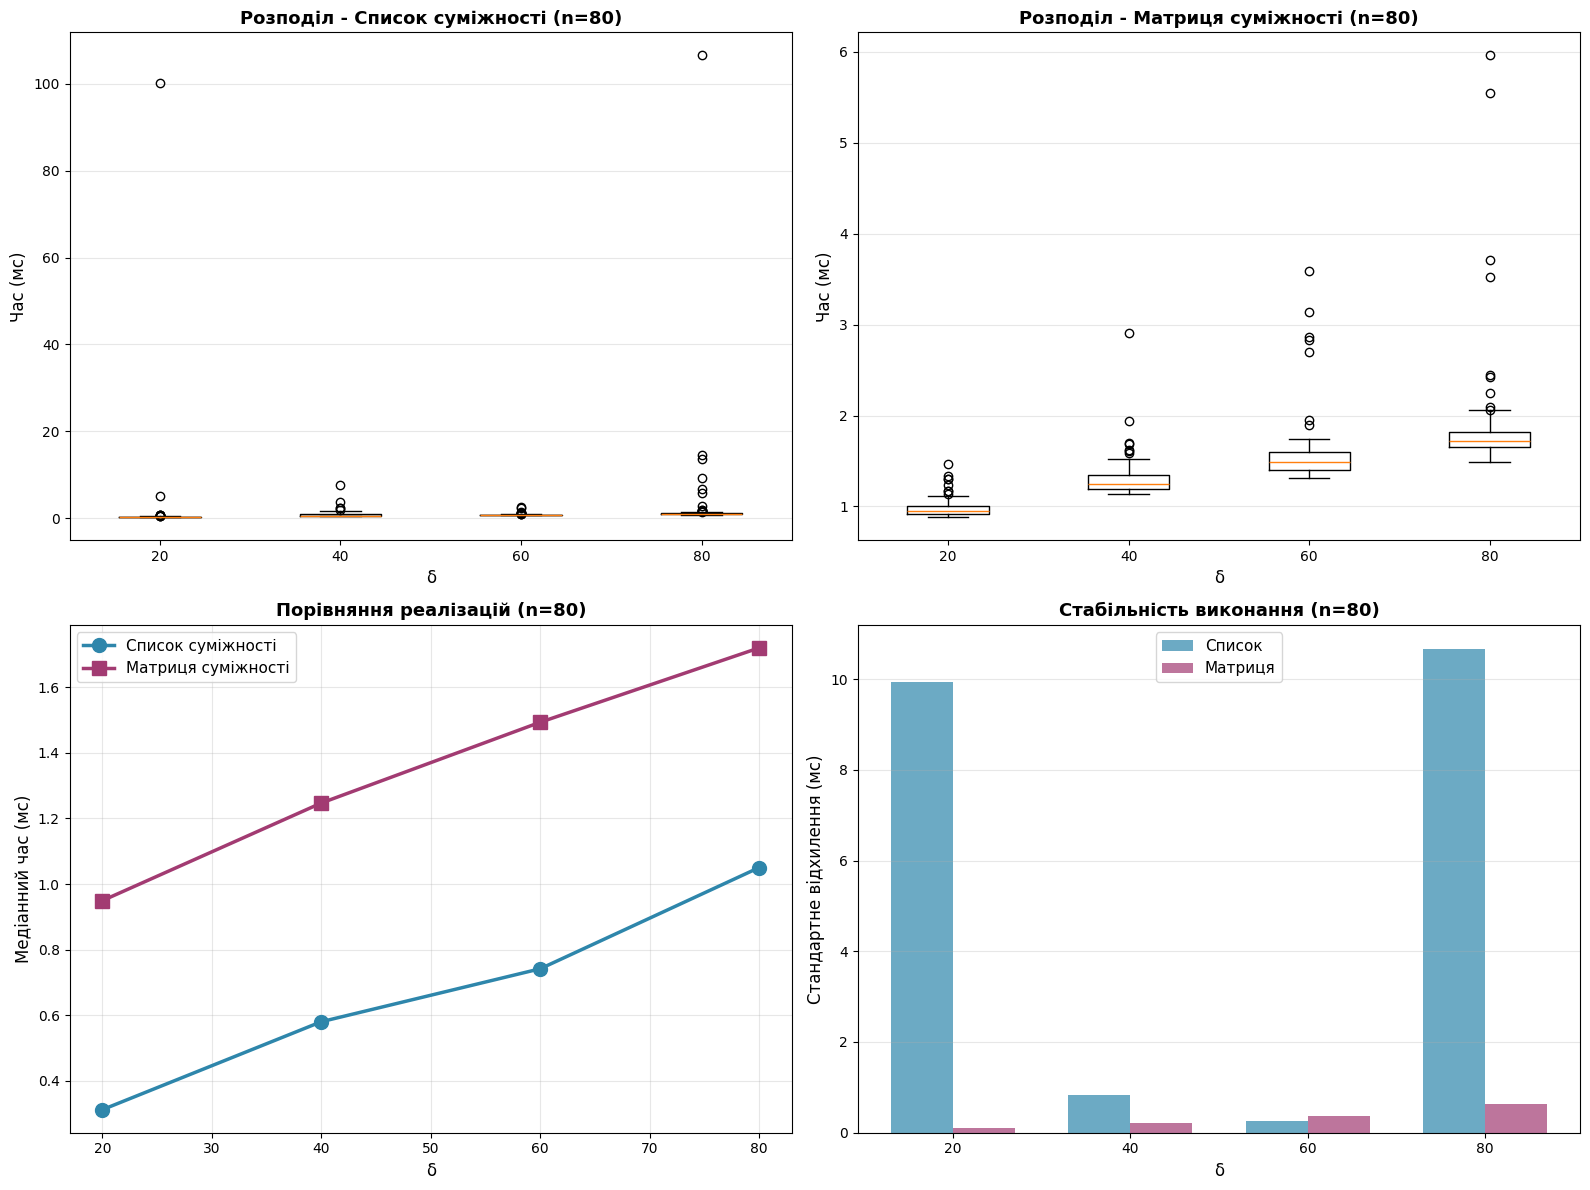

/var/folders/62/q1myyln54rqcbpgt5c6jf_jc0000gn/T/ipykernel_28773/206366845.py:8: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax1.boxplot([time_list[i] * 1000 for i in range(len(delta_values))],
/var/folders/62/q1myyln54rqcbpgt5c6jf_jc0000gn/T/ipykernel_28773/206366845.py:15: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax2.boxplot([time_matrix[i] * 1000 for i in range(len(delta_values))],


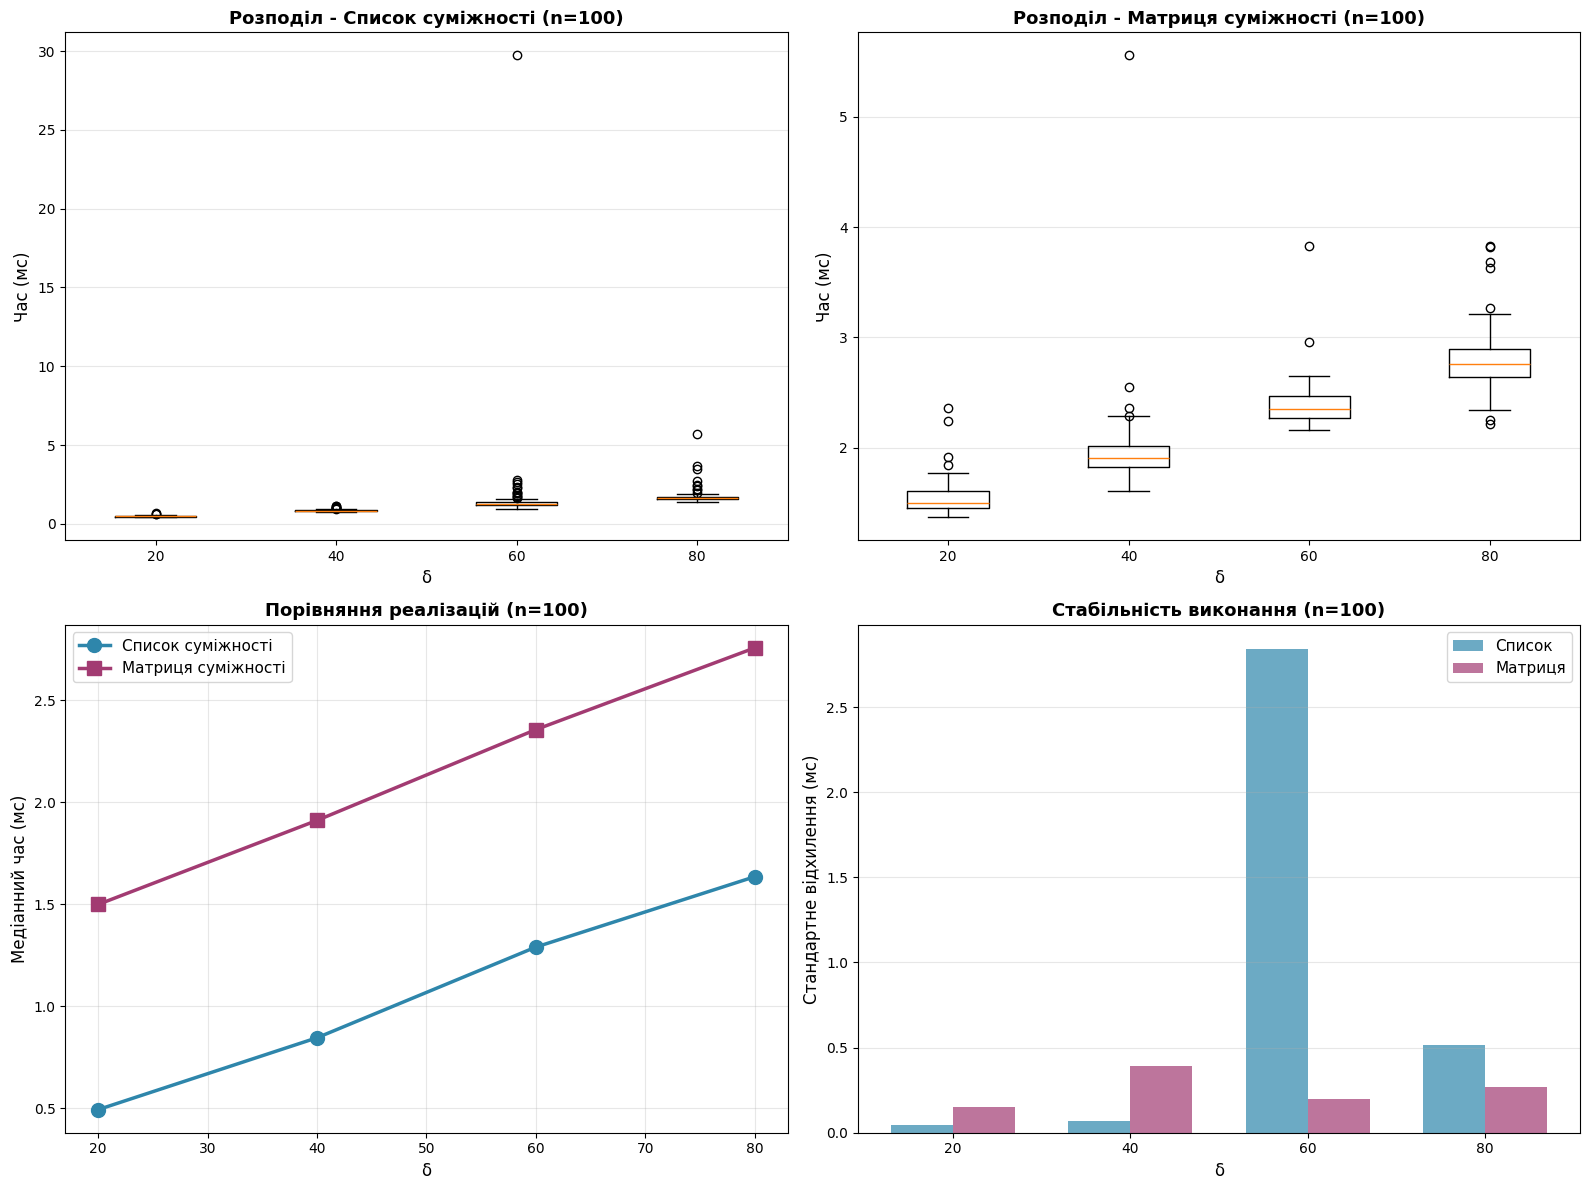

/var/folders/62/q1myyln54rqcbpgt5c6jf_jc0000gn/T/ipykernel_28773/206366845.py:8: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax1.boxplot([time_list[i] * 1000 for i in range(len(delta_values))],
/var/folders/62/q1myyln54rqcbpgt5c6jf_jc0000gn/T/ipykernel_28773/206366845.py:15: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax2.boxplot([time_matrix[i] * 1000 for i in range(len(delta_values))],


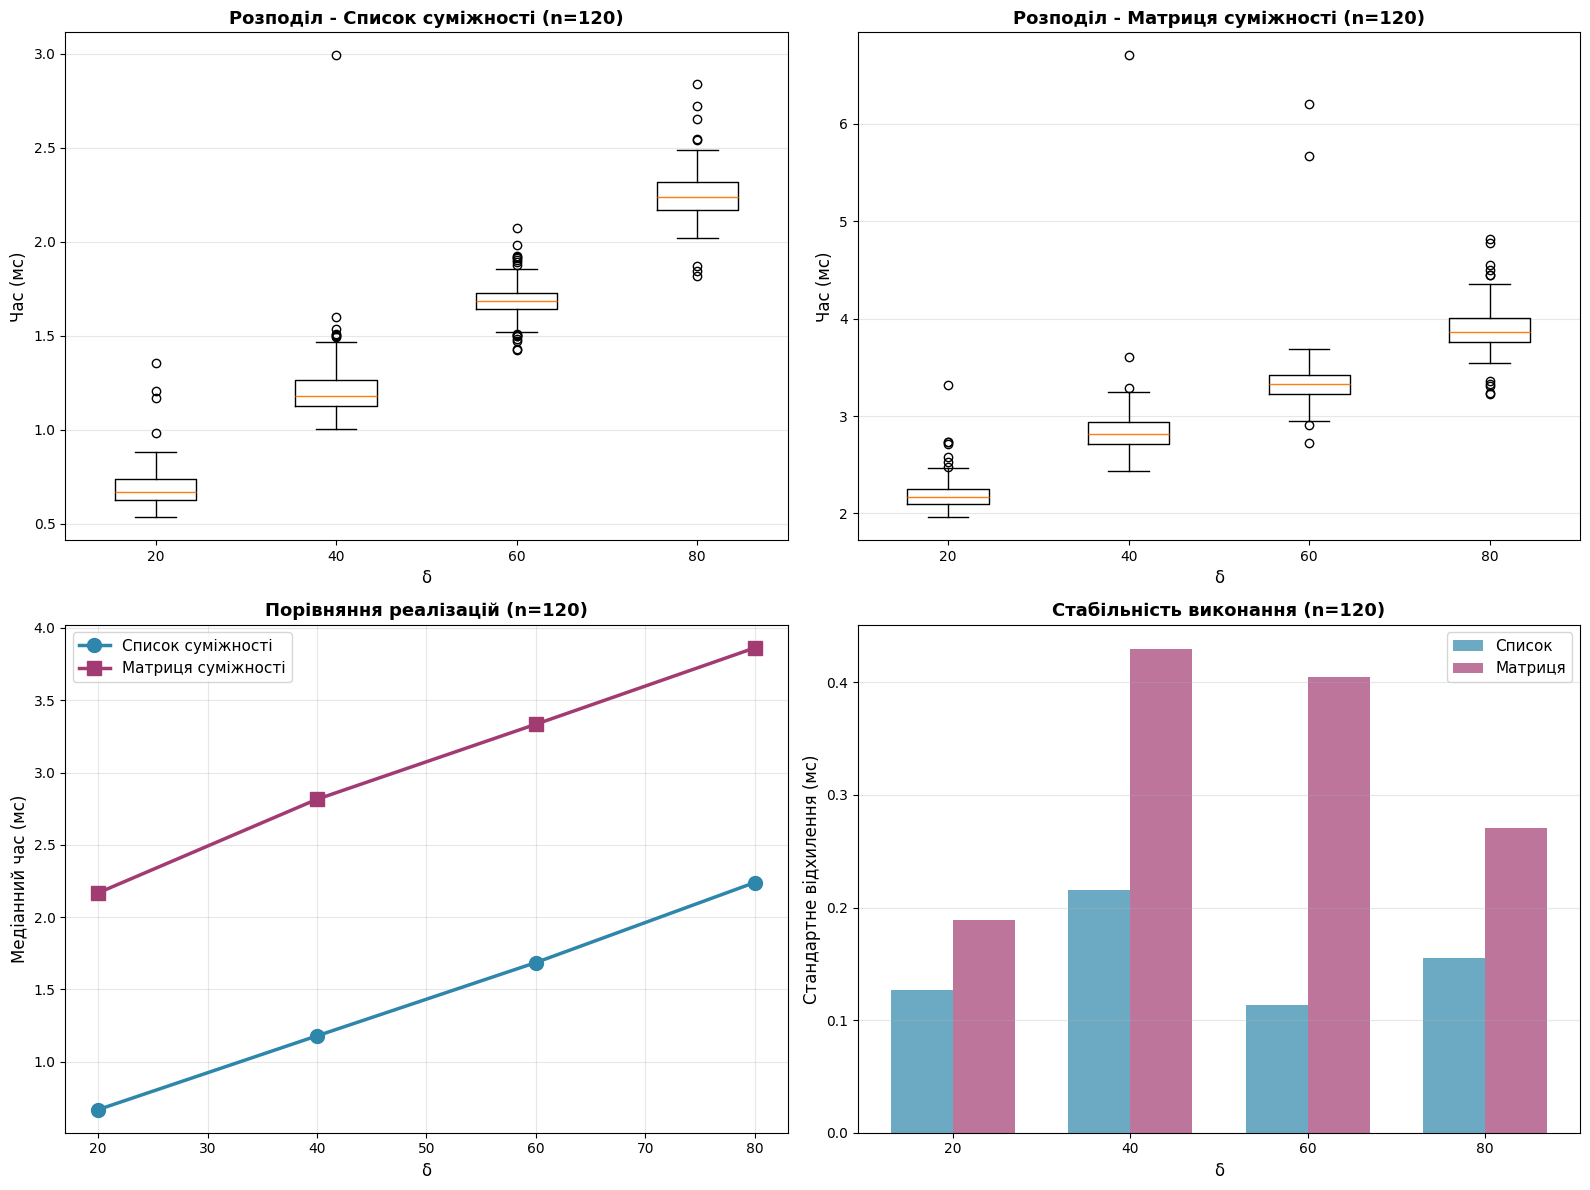

/var/folders/62/q1myyln54rqcbpgt5c6jf_jc0000gn/T/ipykernel_28773/206366845.py:8: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax1.boxplot([time_list[i] * 1000 for i in range(len(delta_values))],
/var/folders/62/q1myyln54rqcbpgt5c6jf_jc0000gn/T/ipykernel_28773/206366845.py:15: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax2.boxplot([time_matrix[i] * 1000 for i in range(len(delta_values))],


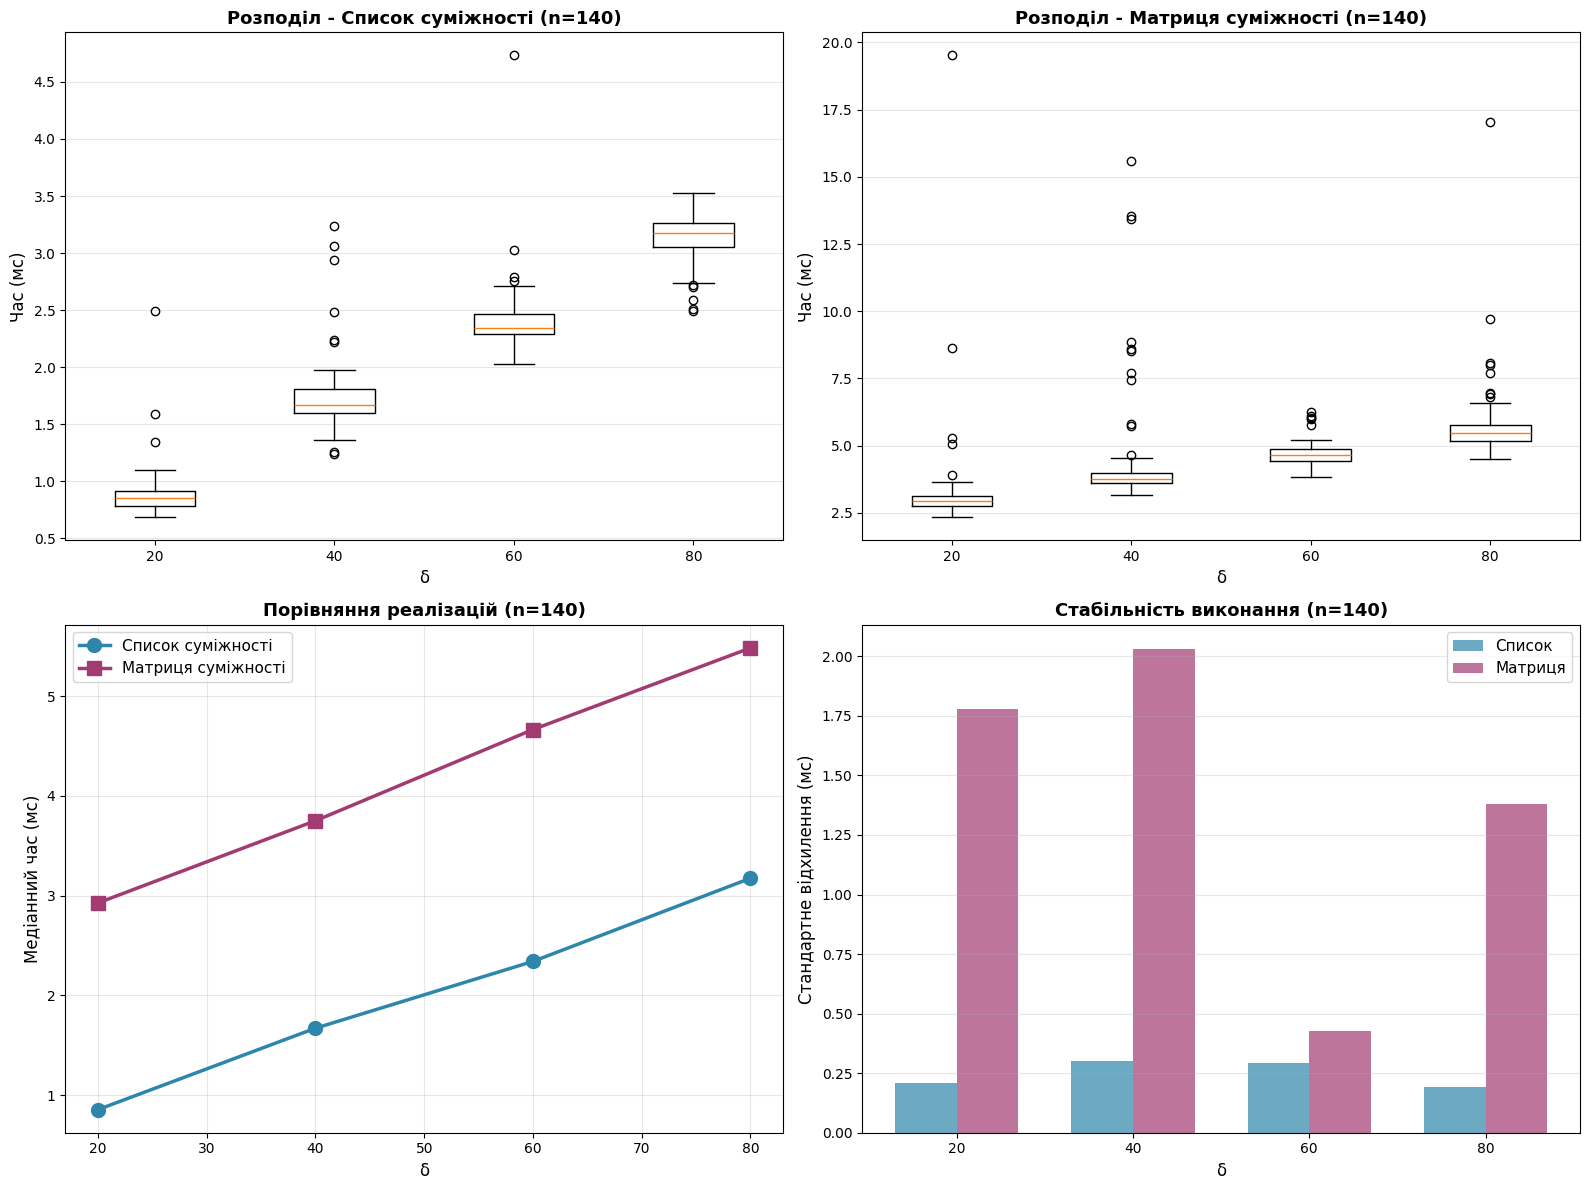

/var/folders/62/q1myyln54rqcbpgt5c6jf_jc0000gn/T/ipykernel_28773/206366845.py:8: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax1.boxplot([time_list[i] * 1000 for i in range(len(delta_values))],
/var/folders/62/q1myyln54rqcbpgt5c6jf_jc0000gn/T/ipykernel_28773/206366845.py:15: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax2.boxplot([time_matrix[i] * 1000 for i in range(len(delta_values))],


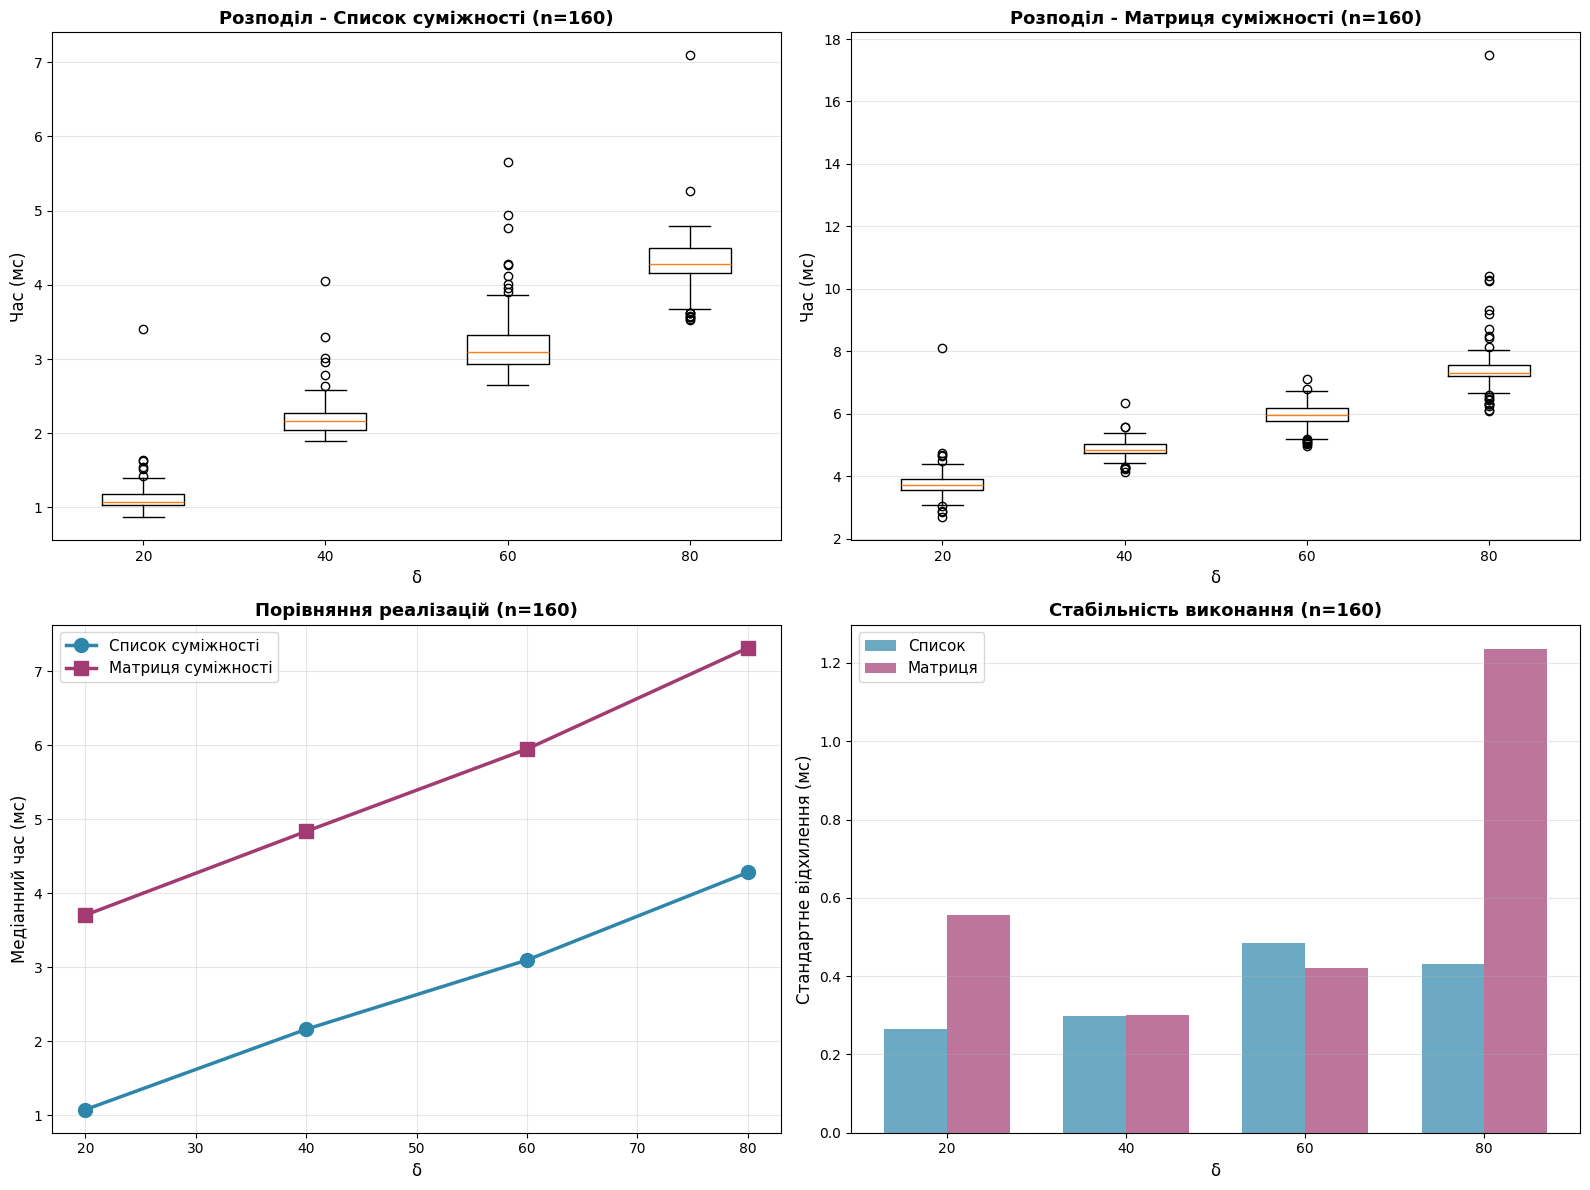

/var/folders/62/q1myyln54rqcbpgt5c6jf_jc0000gn/T/ipykernel_28773/206366845.py:8: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax1.boxplot([time_list[i] * 1000 for i in range(len(delta_values))],
/var/folders/62/q1myyln54rqcbpgt5c6jf_jc0000gn/T/ipykernel_28773/206366845.py:15: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax2.boxplot([time_matrix[i] * 1000 for i in range(len(delta_values))],


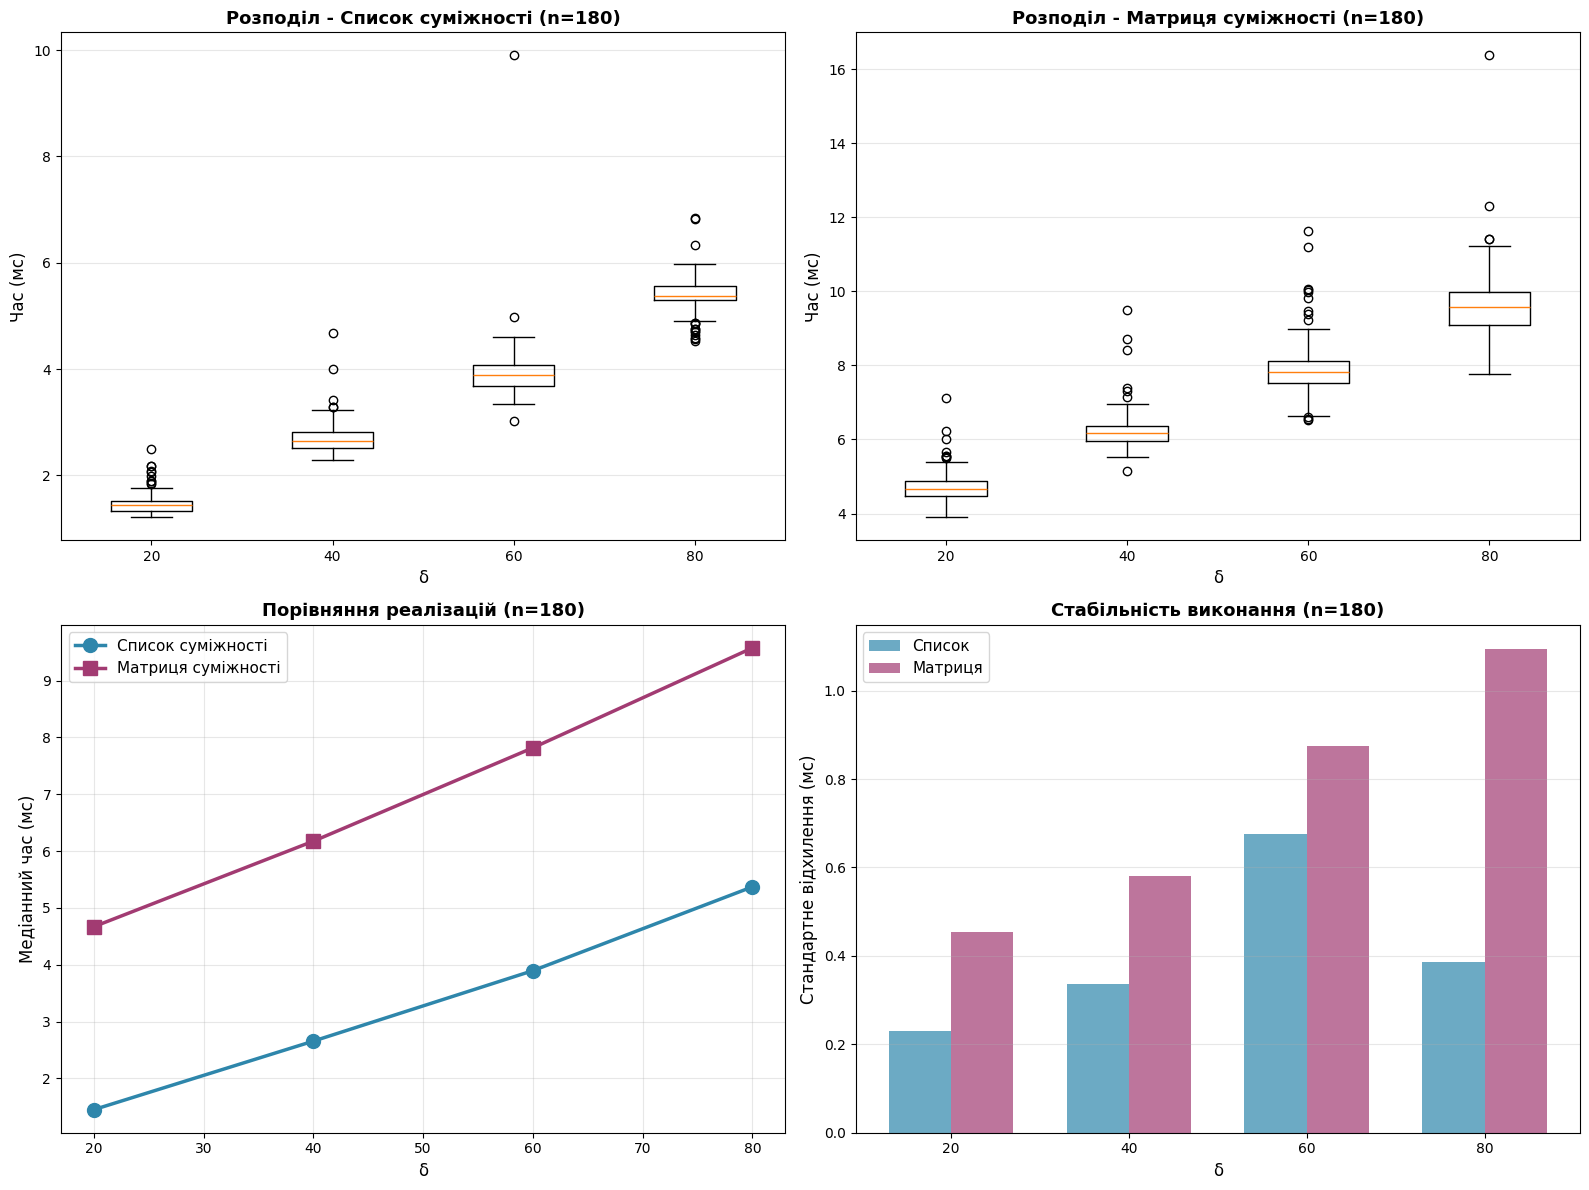

/var/folders/62/q1myyln54rqcbpgt5c6jf_jc0000gn/T/ipykernel_28773/206366845.py:8: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax1.boxplot([time_list[i] * 1000 for i in range(len(delta_values))],
/var/folders/62/q1myyln54rqcbpgt5c6jf_jc0000gn/T/ipykernel_28773/206366845.py:15: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax2.boxplot([time_matrix[i] * 1000 for i in range(len(delta_values))],


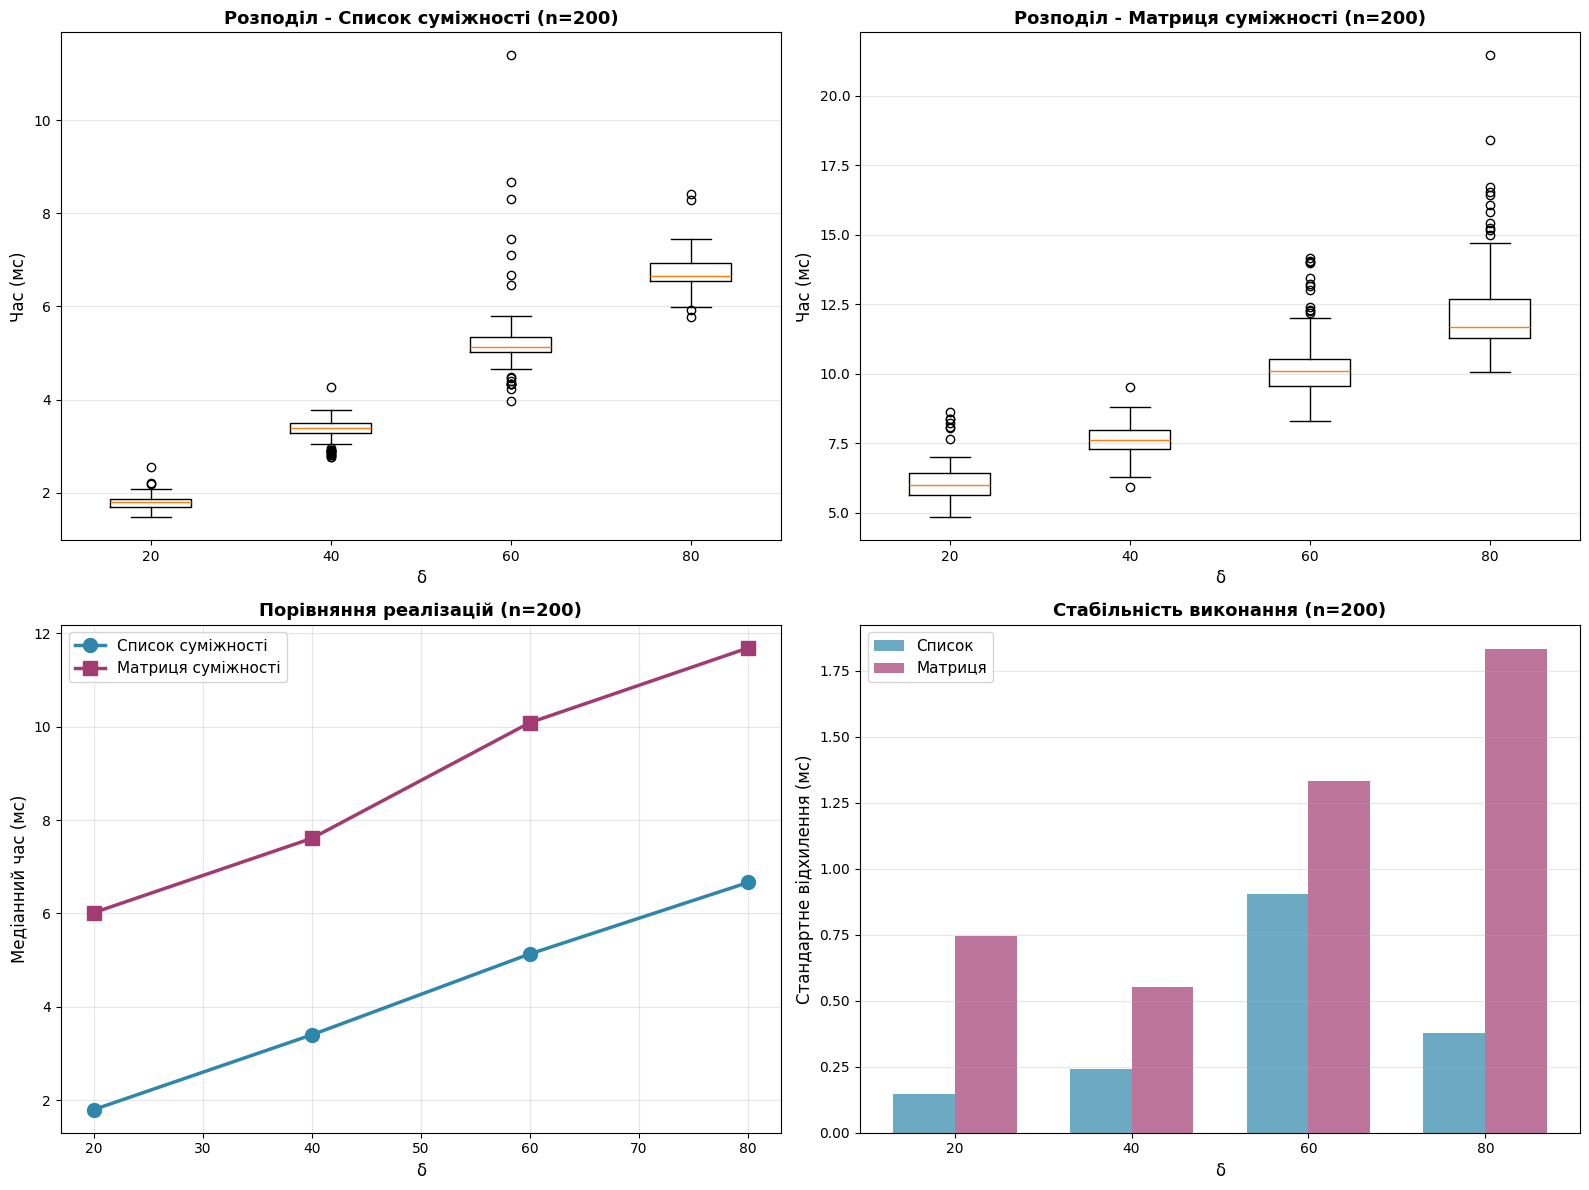

In [88]:
for n in sorted(ALL_RESULTS['adj_list'].keys()):
    plot_individual_n(n, ALL_RESULTS, DELTA_VALUES)